In [1]:
cd /data/store01/data_dirs/students/ucfafyi/S2_MODIS

/data/store01/data_dirs/students/ucfafyi/S2_MODIS


In [2]:
import gdal
import glob 
import gdal
import numpy as np
import numpy.ma as ma
import sys
sys.path.insert(0, 'python')
import kernels
from geo_trans import *
from readSent import *
import pylab as plt
%matplotlib inline
from scipy.interpolate import griddata
from LS_optimizing import *
from Dload_Finder import *
from fft_helper import *
from get_brdf import *
from nicer_plot import *
from linear_plot7 import *

In [3]:
plot_config()

/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
lat, lon, year = 37.474469, 117.346456, 2016
h,v = mtile_cal(lat, lon)
pr=get_wrs(lat, lon)
path, row = pr[0]['path'],pr[0]['row']
Hfiles = glob.glob(directory +'l_data/LC8%03d%03d%d*LGN00_sr_band1.tif'%(path, row, year))

In [5]:
doys = [int(i.split('2016')[1][:3]) for i in Hfiles]
doy = doys[1]; Hsat = 'L'

Hfile = directory +'l_data/LC8%03d%03d%d%03dLGN00_sr_'%(path, row, year, doy)
Lfiles = [glob.glob('m_data/MCD43A1.A%d%03d.h%02dv%02d.006.*.hdf'%(year,i,h,v))[0] for i in range(doy-16, doy+16)]
Hfile, Lfiles

('/data/store01/data_dirs/students/ucfafyi/S2_MODIS/l_data/LC81220342016070LGN00_sr_',
 ['m_data/MCD43A1.A2016054.h27v05.006.2016175061627.hdf',
  'm_data/MCD43A1.A2016055.h27v05.006.2016175063329.hdf',
  'm_data/MCD43A1.A2016056.h27v05.006.2016175065653.hdf',
  'm_data/MCD43A1.A2016057.h27v05.006.2016175072150.hdf',
  'm_data/MCD43A1.A2016058.h27v05.006.2016175074736.hdf',
  'm_data/MCD43A1.A2016059.h27v05.006.2016175081302.hdf',
  'm_data/MCD43A1.A2016060.h27v05.006.2016175083705.hdf',
  'm_data/MCD43A1.A2016061.h27v05.006.2016175181953.hdf',
  'm_data/MCD43A1.A2016062.h27v05.006.2016179112948.hdf',
  'm_data/MCD43A1.A2016063.h27v05.006.2016179114849.hdf',
  'm_data/MCD43A1.A2016064.h27v05.006.2016179121055.hdf',
  'm_data/MCD43A1.A2016065.h27v05.006.2016179123717.hdf',
  'm_data/MCD43A1.A2016066.h27v05.006.2016179125223.hdf',
  'm_data/MCD43A1.A2016067.h27v05.006.2016179131610.hdf',
  'm_data/MCD43A1.A2016068.h27v05.006.2016179133745.hdf',
  'm_data/MCD43A1.A2016069.h27v05.006.20161

In [37]:
tems[0][-1]

43.274648980000002

In [10]:
val_ins, val_brdf = get_brdf_six(Lfiles[8],(tems[0][-2:], tems[1][-2:], tems[2][-2:]), Linds= L_inds)

In [7]:
with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
    for line in inF:
        if 'CLOUD_COVER ' in line:
            cloud_cover =  float(line.split('= ')[1])
if cloud_cover<20:
    print 'Less than 20% cloud.'
    b1 = gdal.Open(Hfile+'band1.tif').ReadAsArray()
    corners = b1.shape

    cloud = gdal.Open(Hfile[:-4]+'_cfmask.tif').ReadAsArray()
    cl_mask = cloud==4 # cloud pixels; strictest way is to set the clear pixels with cloud==0

    dic = {}

    with open(Hfile[:-4]+'_MTL.txt', 'r') as inF:
        for line in inF:
            if ('CORNER_' in line)&('LAT_PRODUCT' in line):
                dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
            elif ('CORNER_' in line)&('LON_PRODUCT' in line):
                dic[line.split(' = ')[0].strip()[7:13]] = float(line.split(' = ')[1])
            elif 'ROLL_ANGLE' in line:
                vza = float(line.split(' = ')[1])
            elif 'SUN_AZIMUTH' in line:
                saa = float(line.split(' = ')[1])
            elif 'SUN_ELEVATION' in line:
                sza = float(line.split(' = ')[1])
    with open('Landsat_azm.pkl', 'r') as savefile:
        Landsat_azm = pkl.load(savefile)

    lazm = np.nanmean(Landsat_azm[(Landsat_azm[:,2]==path)&(Landsat_azm[:,3]==row)].squeeze()[:2])
    raa = lazm-saa

    L_inds, H_inds = ML_geo_trans(lat, lon, dic, corners)

    tems = np.zeros((3,6))
    tems[0,:] = sza
    tems[1,:] = vza
    tems[2,:] = raa
    #brdfs = np.array([get_brdf_six(Lfile, (tems[0], tems[1], tems[2]), bands=[3,4,1,2,6,7]) for Lfile in Lfiles])
    #brdfs.mask = brdfs.mask|(rws<1)
    #args = Hfile, cloud, brdfs, H_inds, L_inds

Less than 20% cloud.


In [8]:
import gdal
import numpy as np
import numpy.ma as ma
import sys
sys.path.insert(0, 'python')
import kernels
from geo_trans import *
from readSent import *

def r_modis(fname):
    g = gdal.Open(fname)
    if g is None:
        raise IOError
    else:
        return g.ReadAsArray()


def ScaleExtent(data, shape): # used for unifine different array,

    re = int(shape[0]/(data.shape[0]))

    a = np.repeat(np.repeat(data, re, axis = 1), re, axis =0)
    
    if re*(data.shape[0]-shape[0]) != 0:
        extended = np.zeros(shape)
        extended[:re*(data.shape[0]),:re*(data.shape[0])] = a
        extended[re*(data.shape[0]):,re*(data.shape[0]):] = a[re*(data.shape[0])-shape[0]:, re*(data.shape[0])-shape[0]]
        return extended
    else:
        return a
#bands = [2,3,4,8,13,11,12]


def get_kk(angles):
    vza ,sza,raa = angles
    kk = kernels.Kernels(vza ,sza,raa,\
                         RossHS=False,MODISSPARSE=True,\
                         RecipFlag=True,normalise=1,\
                         doIntegrals=False,LiType='Sparse',RossType='Thick')
    return kk


def qa_to_ReW(modisQAs, bands):
    magic = 0.618034
    modis = r_modis(modisQAs[3][0])
    QA = np.array([np.right_shift(np.bitwise_and(modis, np.left_shift(15,i*4)), i*4) for i in np.arange(0,7)])[bands,]
    relative_W = magic**QA
    relative_W[relative_W<magic**4]=0
    return relative_W

def get_rs(modisQAs, modis_filenames, angles, bands = range(7)):
    
    kk = get_kk(angles)
    k_vol = kk.Ross
    k_geo = kk.Li

    br = np.array([r_modis(modis_filenames[i][0]) for i in bands])
    mask = (br[:,0,:,:] > 32766) | (br[:,1,:,:] > 32766) |(br[:,2,:,:] > 32766)
    rw = qa_to_ReW(modisQAs, bands) # correpsonding relative weights
    brdf = br[:,0,:,:] + (br[:,1,:,:].T*k_vol).T + (br[:,2,:,:].T*k_geo).T
    brdf = ma.array(brdf, mask = mask)

    return [brdf,rw]


def get_brdf_six(fname, angles, bands = None):
    
    
    temp1 = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_BRDF:BRDF_Albedo_Parameters_Band%d'
    temp2 = 'HDF4_EOS:EOS_GRID:"%s":MOD_Grid_BRDF:BRDF_Albedo_Band_Mandatory_Quality_Band%d'
    
    kk = get_kk(angles)
    k_vol = kk.Ross
    k_geo = kk.Li

    br = np.array([r_modis(temp1%(fname, band)) for band in bands])
    qa = np.array([r_modis(temp2%(fname, band)) for band in bands])
    #mask = (br[:,0,:,:] > 32766) | (br[:,1,:,:] > 32766) |(br[:,2,:,:] > 32766)
    brdf = br[:,0,:,:] + (br[:,1,:,:].T*k_vol).T + (br[:,2,:,:].T*k_geo).T
    #brdf = ma.array(brdf, mask = mask)

    return [brdf,qa]

In [9]:
brdfs = np.array([get_brdf_six(Lfile, (tems[0][-1], tems[1][-1], tems[2][-1]), bands=[7,]) for Lfile in Lfiles])

In [10]:
brdfs.shape

(32, 2, 1, 2400, 2400)

In [11]:
Lx, Ly = L_inds
Hx, Hy = H_inds
L_inds, H_inds

((array([354, 354, 354, ..., 864, 864, 864]),
  array([ 188,  189,  190, ..., 1316, 1317, 1318])),
 array([[  10,   10,   10, ..., 7842, 7842, 7842],
        [   1,   17,   32, ..., 7655, 7671, 7686]]))

In [127]:
brdfs[0][0].shape

(6, 2400, 2400)

In [12]:
b7s = brdfs[:,:,-1,:,:]

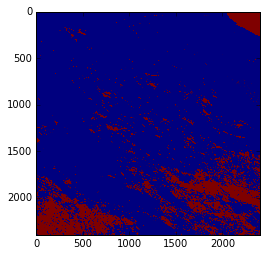

In [51]:
m7s = b7s[:,1,:,:]
plt.imshow(np.all(m7s>1, axis=0))

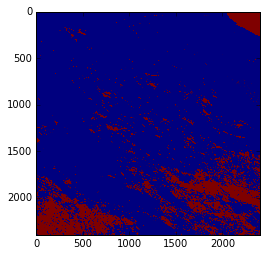

In [84]:
qa_mask = np.all(m7s>2, axis=0)
plt.imshow(qa_mask)

In [13]:
struct = ndimage.generate_binary_structure(2, 2)
dia_cloud = ndimage.binary_dilation(cl_mask, structure=struct, iterations=20).astype(cl_mask.dtype)

In [14]:
ind=5
B_num = L_bands[ind]
print B_num
H_data = gdal.Open(Hfile+'band%d.tif'%B_num).ReadAsArray()*0.0001
mask = ~(H_data<0).astype('bool')
small_mask = ndimage.binary_erosion(mask, structure=struct, iterations=20).astype(mask.dtype)
val_mask = (~dia_cloud)&small_mask

7


7


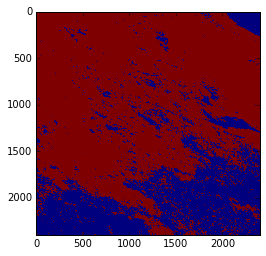

In [9]:
L_data = brdfs[ind]
qa_masks = rws<2
qa_mask = qa_masks[ind]
plt.imshow(qa_masks[0])

In [15]:
avker = np.ones((40,40))
navker = avker/avker.sum()
s = signal.fftconvolve(H_data, navker, mode='same')
outs = ~val_mask
s[outs]=np.nan

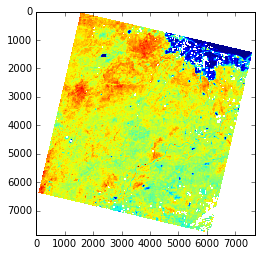

In [105]:
plt.imshow(s)

In [16]:
Ldatas = b7s[:,0,:,:]*0.001
Lmasks = b7s[:,1,:,:]

In [108]:
Ldatas.shape

((16, 2400, 2400), array([[   0.,    0.,    0., ...,  255.,  255.,  255.],
        [   0.,    0.,    0., ...,  255.,  255.,  255.],
        [   0.,    0.,    0., ...,  255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.],
        [ 255.,  255.,  255., ...,  255.,  255.,  255.]]))

In [17]:
xs, ys =33.11601562,   4.95605469
val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
to_regs = []
results = []
for i,L_data in enumerate(Ldatas):
    Lvals, Hvals =L_data[Lx[val], Ly[val]], s[shx[val], shy[val]]
    qa_mask = Lmasks[i]<1
    
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)&(qa_mask[Lx[val], Ly[val]])
    to_regs.append( [Lvals[mas], Hvals[mas]])
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    results.append([i+1, r.rvalue, r.slope, r.intercept, len(Lvals[mas])])
    print 'DOY: ',i+1,' Correlation: ', r.rvalue, ' Slope: ', r.slope, ' Intercept: ', r.intercept, ' Points: ', len(Hvals[mas])

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in less


DOY:  1  Correlation:  0.900342696904  Slope:  1.09488625059  Intercept:  0.023876440747  Points:  68786
DOY:  2  Correlation:  0.916115730797  Slope:  1.07422066841  Intercept:  0.0203646512325  Points:  75509
DOY:  3  Correlation:  0.946945532236  Slope:  1.10136215282  Intercept:  0.0110641399279  Points:  35902
DOY:  4  Correlation:  0.9736699679  Slope:  1.1180643251  Intercept:  0.00442754656785  Points:  13661
DOY:  5  Correlation:  0.983480267529  Slope:  1.10114969873  Intercept:  -0.000554607959234  Points:  8203
DOY:  6  Correlation:  0.983681994692  Slope:  1.10058280339  Intercept:  -0.000689745742853  Points:  8225
DOY:  7  Correlation:  0.983804636467  Slope:  1.0863068365  Intercept:  -0.00168162161562  Points:  9528
DOY:  8  Correlation:  0.983527461654  Slope:  1.08604121873  Intercept:  -0.00178139241616  Points:  9404
DOY:  9  Correlation:  0.983041787096  Slope:  1.08708365474  Intercept:  -0.00235538579991  Points:  10197
DOY:  10  Correlation:  0.979725435565  Sl

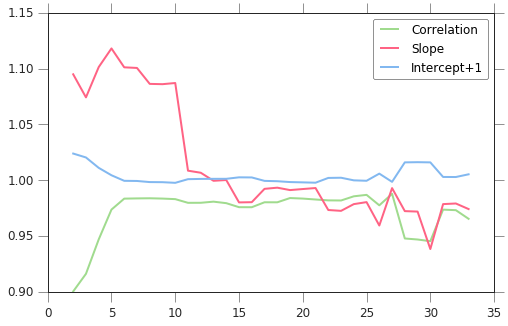

In [26]:
plt.figure(figsize=(8,5))
results = np.array(results)
plt.plot(results[:,0]+1, results[:,1],label = 'Correlation', color='#A0DB8E')
plt.plot(results[:,0]+1, results[:,2],label = 'Slope', color='#FF6384')
plt.plot(results[:,0]+1, results[:,3]+1,label = 'Intercept+1', color='#82b8f0')
plt.legend()

In [19]:
ldata = [i[0] for i in to_regs[:5]]
hdata = [i[1] for i in to_regs[:5]]

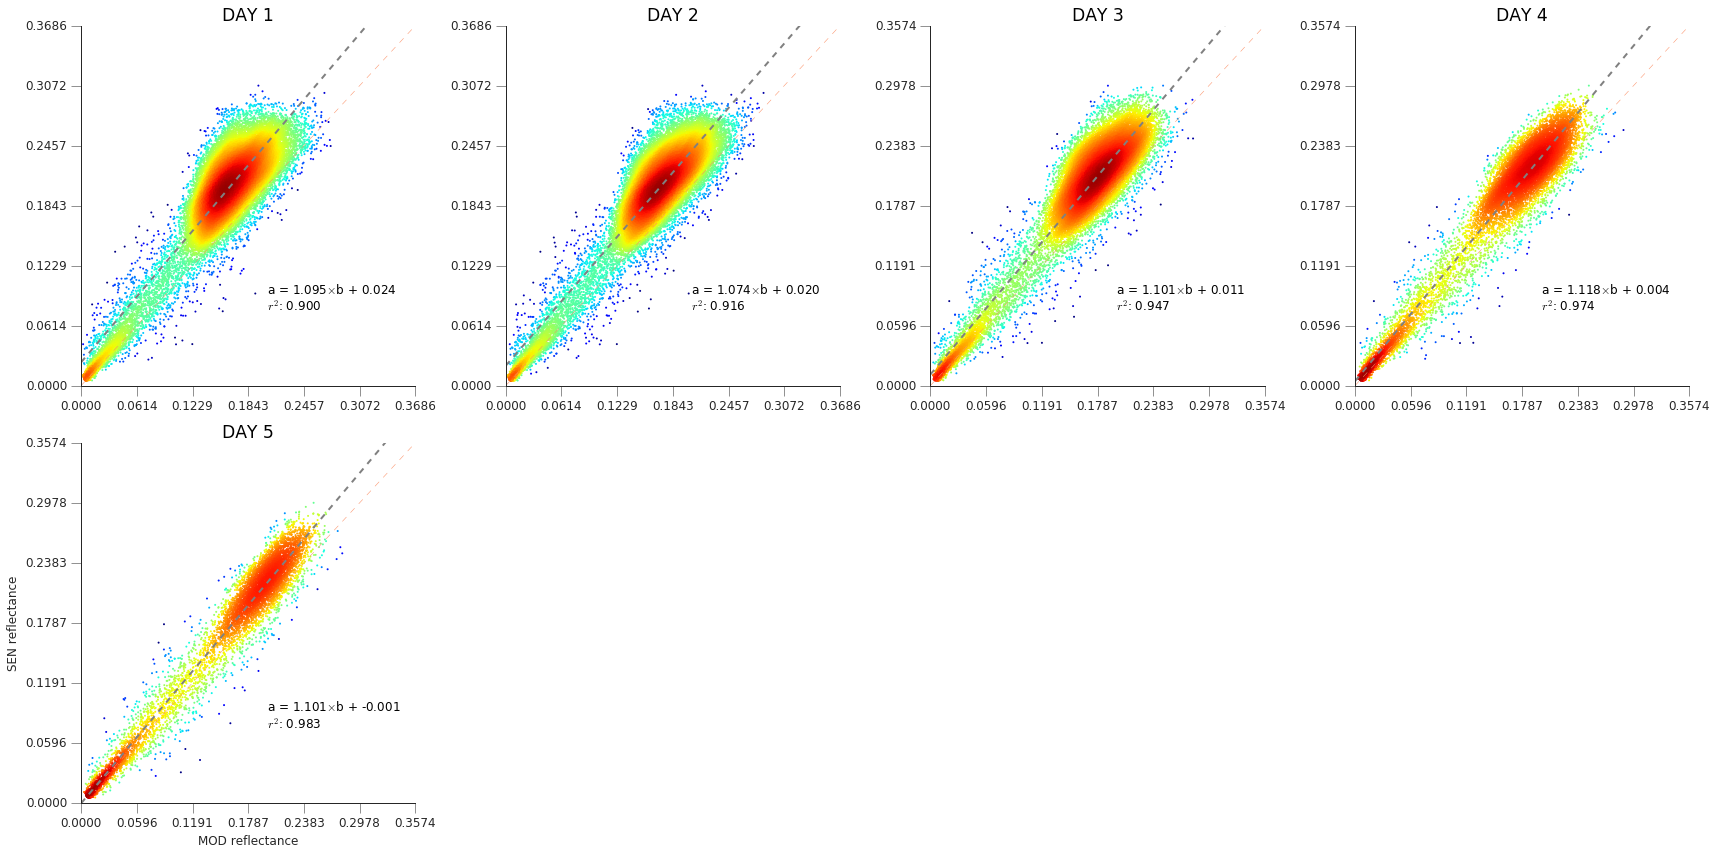

In [20]:
linear_plots(ldata, hdata, cmap=plt.cm.get_cmap('jet'), 
             titles=['DAY 1','DAY 2','DAY 3','DAY 4','DAY 5'], three_sigma=0)

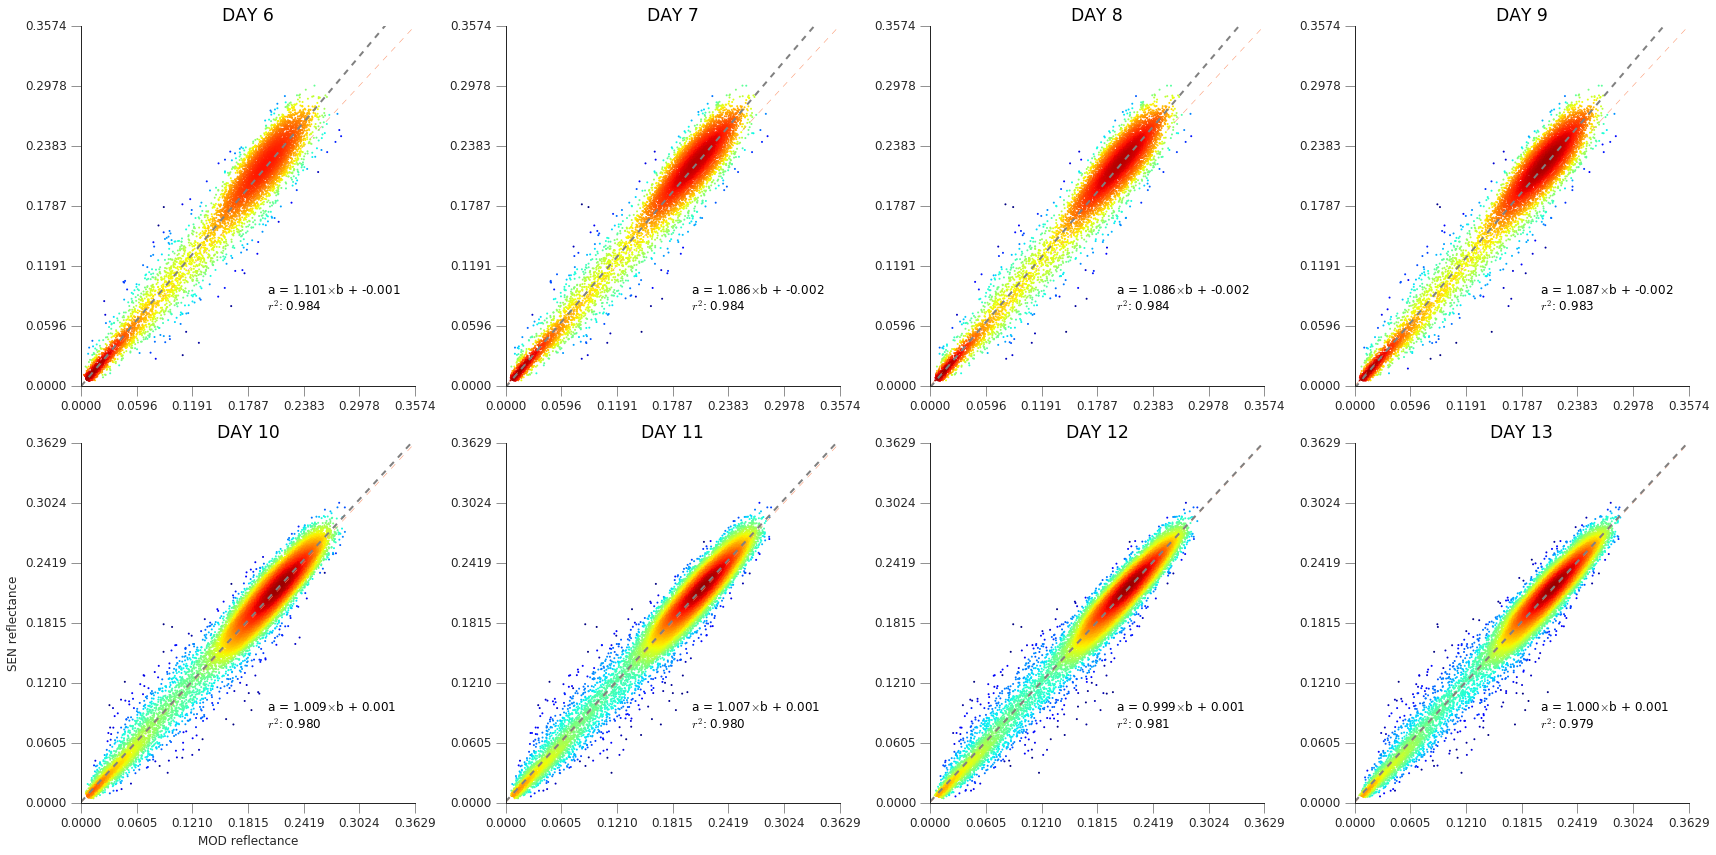

In [22]:
ldata2 = [i[0] for i in to_regs[5:13]]
hdata2 = [i[1] for i in to_regs[5:13]]
linear_plots(ldata2, hdata2, cmap=plt.cm.get_cmap('jet'), 
             titles=['DAY 6','DAY 7','DAY 8','DAY 9','DAY 10', 'DAY 11','DAY 12','DAY 13'], three_sigma=0)
plt.savefig('day6-13.pdf')

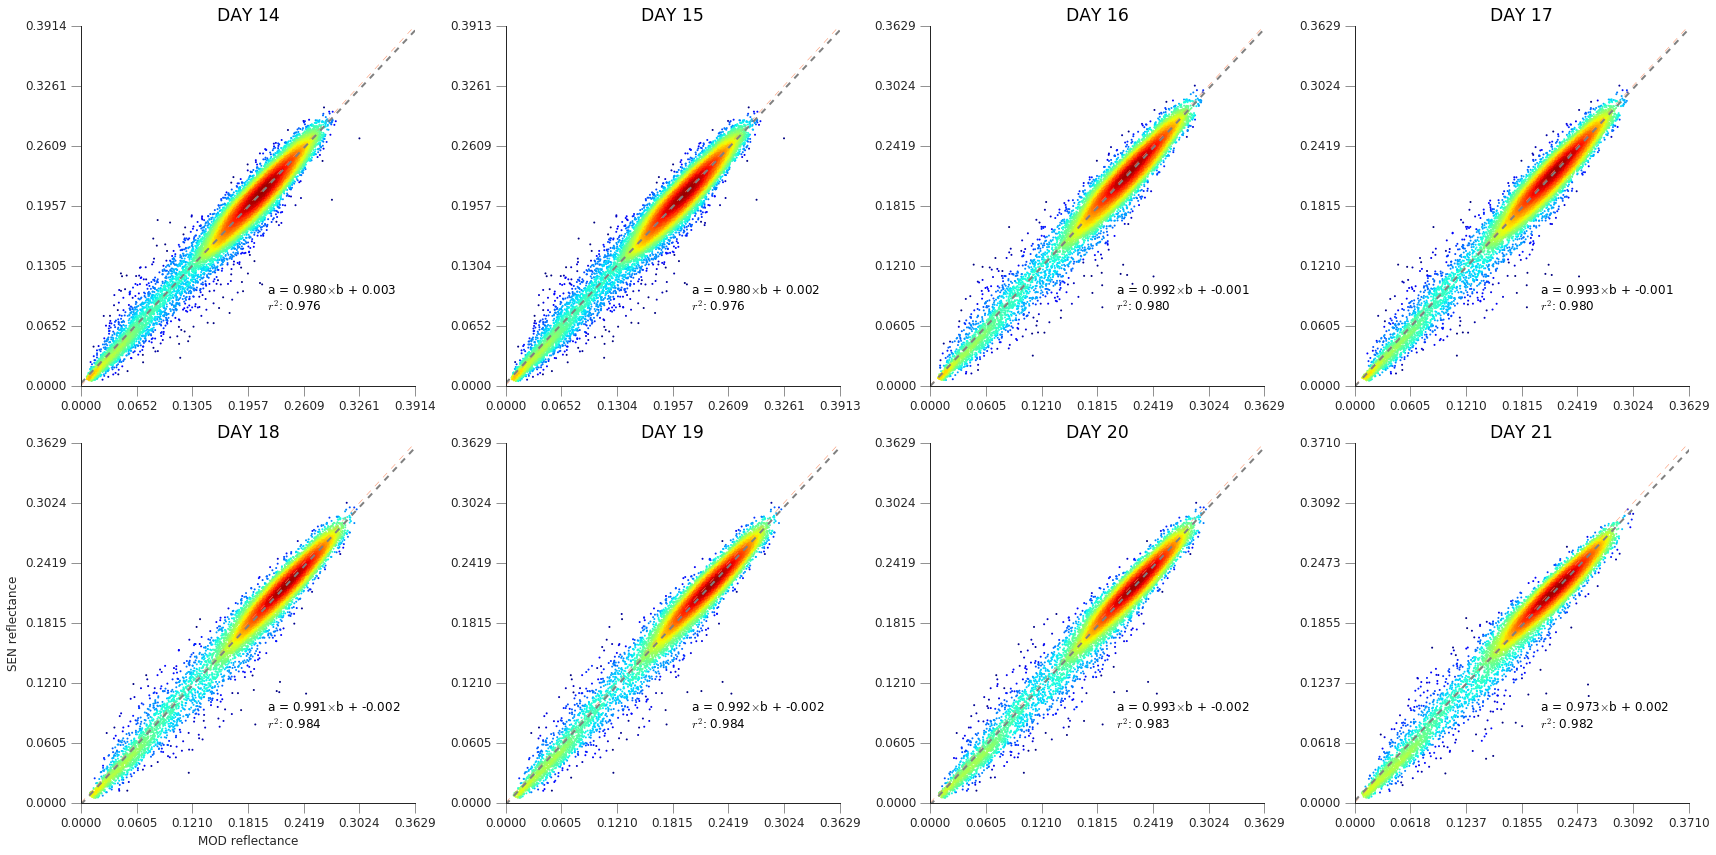

In [23]:
ldata2 = [i[0] for i in to_regs[13:21]]
hdata2 = [i[1] for i in to_regs[13:21]]
linear_plots(ldata2, hdata2, cmap=plt.cm.get_cmap('jet'), 
             titles=['DAY 14','DAY 15','DAY 16','DAY 17','DAY 18', 'DAY 19','DAY 20','DAY 21'], three_sigma=0)
plt.savefig('day14-21.pdf')

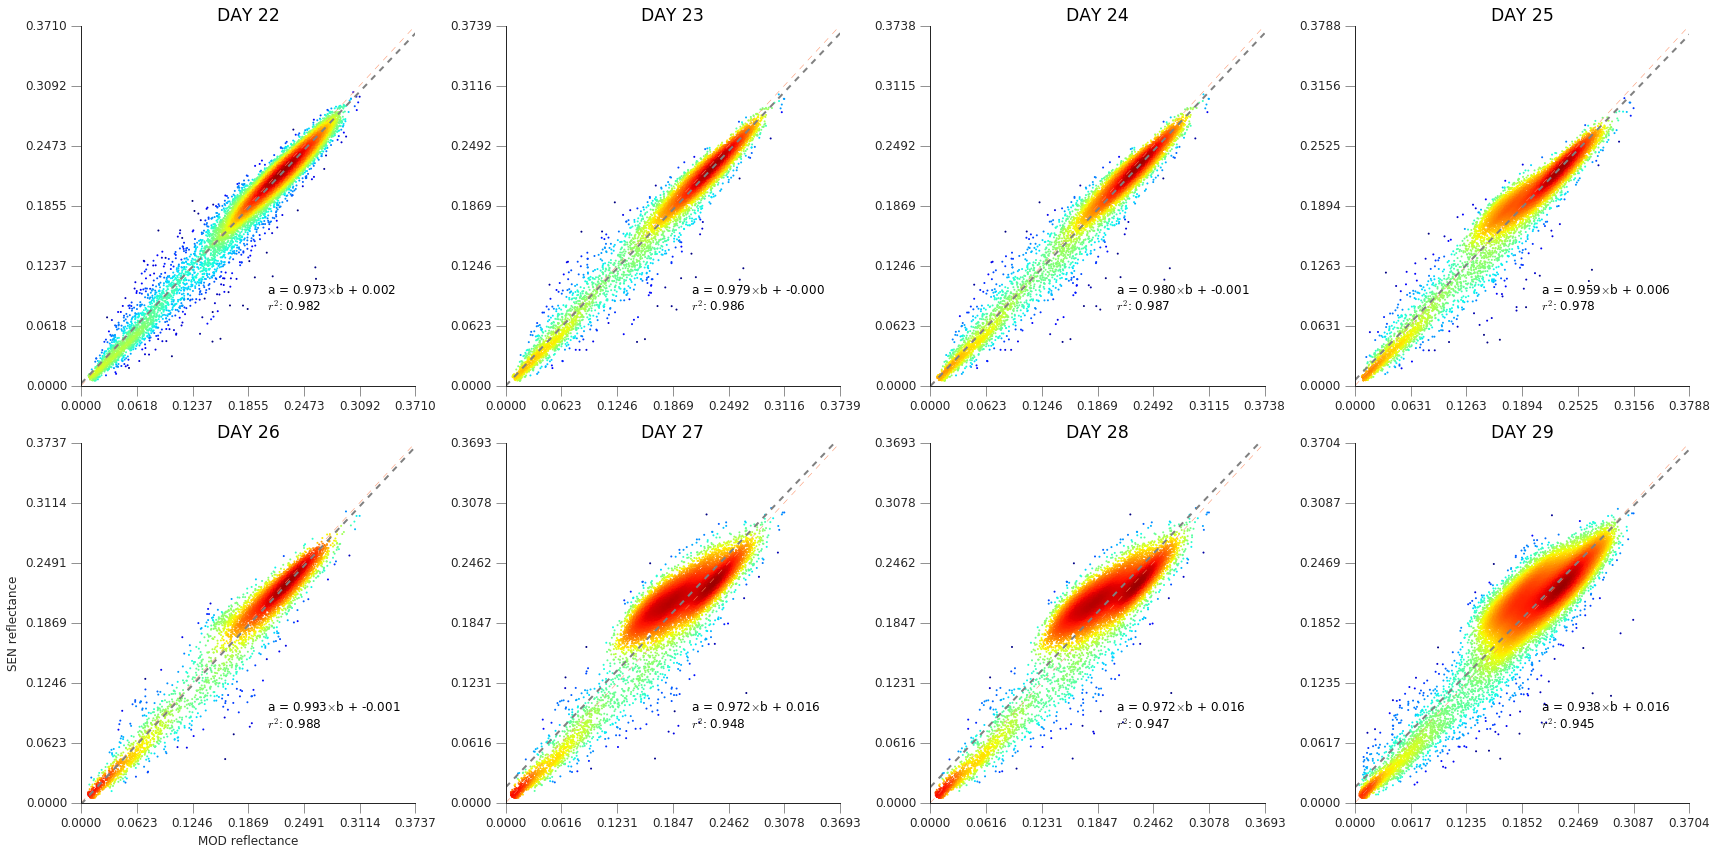

In [24]:
ldata2 = [i[0] for i in to_regs[21:29]]
hdata2 = [i[1] for i in to_regs[21:29]]
linear_plots(ldata2, hdata2, cmap=plt.cm.get_cmap('jet'), 
             titles=['DAY 22','DAY 23','DAY 24','DAY 25','DAY 26', 'DAY 27','DAY 28','DAY 29'], three_sigma=0)
plt.savefig('day22-29.pdf')

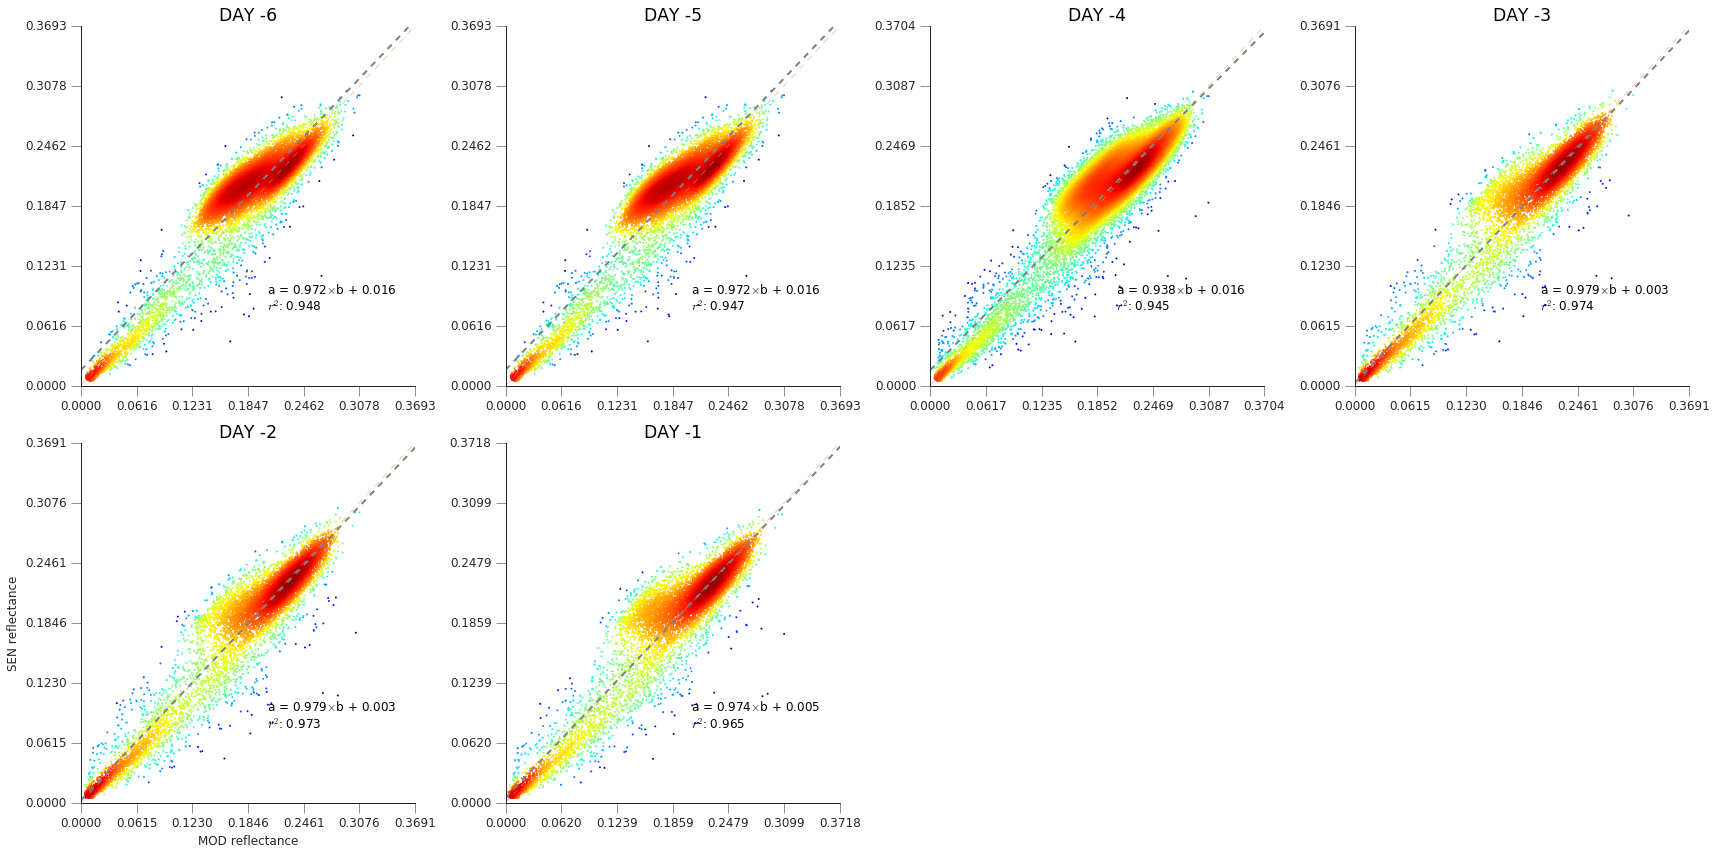

In [21]:
ldata1 = [i[0] for i in to_regs[-6:]]
hdata1 = [i[1] for i in to_regs[-6:]]
linear_plots(ldata1, hdata1, cmap=plt.cm.get_cmap('jet'), 
             titles=['DAY -6','DAY -5','DAY -4','DAY -3','DAY -2', 'DAY -1'], three_sigma=0)

In [ ]:
'''for i in range(4):
    ldata1 = [k[0] for k in to_regs[i*8: (i+1)*8]]
    hdata1 = [k[1] for k in to_regs[i*8: (i+1)*8]]
    linear_plots(ldata1, hdata1, cmap=plt.cm.get_cmap('jet'), 
              titles=['DAY %02d'%(j+1) for j in range(i*8, (i+1)*8)], three_sigma=0)
    plt.savefig('day%02d-%02d.pdf'%(i*8+1, (i+1)*8), dpi=400)
'''

In [20]:
def cost1(shifts):
    xs, ys = shifts
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals =L_data[Lx[val], Ly[val]]*0.001, s[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)&(~Lvals.mask)&(qa_mask[Lx[val], Ly[val]])
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    print xs, ys
    return abs(1-r.rvalue)

In [21]:
retval1=0,0.2
for xstd0 in range(-30,30,15):
    for ystd0 in range(-30,30,15):
        p0 = np.array([xstd0, ystd0])
        retval = optimize.fmin(cost1,p0,full_output=1)
        if retval[1]<retval0[1]:
            retval1=retval            

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


-30.0 -30.0
-31.5 -30.0
-30.0 -31.5
-28.5 -31.5
-28.5 -30.0
-27.75 -29.25
-29.25 -27.75
-27.0 -27.0
-25.5 -25.5
-24.0 -27.0
-21.375 -26.625
-19.125 -22.875
-14.8125 -19.6875
-10.6875 -20.8125
-3.28125 -18.46875
3.28125 -11.53125
15.609375 -3.984375
27.140625 -2.765625
48.1171875 5.6953125
46.03125 11.71875
57.5625 12.9375
26.09765625 0.24609375
7.20703125 -14.23828125
36.3251953125 5.2294921875
35.2822265625 8.2412109375
45.509765625 13.224609375
30.9506835938 3.49072265625
31.9936523438 0.47900390625
32.8157958984 2.41955566406
27.4412841797 0.680786132812
34.1042175293 4.09231567383
35.969329834 3.02114868164
32.2053451538 3.3733291626
33.4937667847 5.04608917236
31.5948944092 4.32710266113
30.3064727783 2.65434265137
32.6969432831 4.44815254211
33.3073940277 3.49437904358
32.0230193138 4.11892175674
32.5146174431 5.19374513626
32.4372993708 4.73864114285
32.2826632261 3.82843315601
32.3986403346 4.51108914614
32.3599812984 4.28353714943
32.5671213269 4.59339684248
32.4898032546 4.13

In [22]:
retval0

(array([ 32.69694328,   4.44815254]), 0.031177461968561748, 36, 93, 0)

In [15]:
s1, s2 = np.array(H_data.shape), np.array([40,40]) # Gasussian size
shape = s1 + s2 - 1
fshape = [next_fast_len(int(i)) for i in shape]
fslice = tuple([slice(0, int(sz)) for sz in shape])
sp1 = np.fft.rfftn(H_data, fshape)

In [16]:
def cost3(paras):
    xstd,ystd,angle,xs, ys = paras
    print paras
    xwin,ywin = 40,40
    G = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
    ker = G/(G.sum())
    sp2 = np.fft.rfftn(ker, fshape)
    ret = (np.fft.irfftn(sp1 * sp2, fshape)[fslice])
    ss = _centered(ret, s1)
    
    #s = signal.fftconvolve(H_data, ker, mode='same')
    # remove the cloud pixel
    ss[outs]=np.nan
    val = (Hx+xs<H_data.shape[0])&(Hy+ys<H_data.shape[1])
    shx, shy = (Hx+xs).astype(int), (Hy+ys).astype(int)
    Lvals, Hvals =L_data[Lx[val], Ly[val]]*0.001, ss[shx[val], shy[val]]
    mas = (Lvals>0)&(Lvals<1)&(Hvals>0)&(Hvals<1)&(~Lvals.mask)&(qa_mask[Lx[val], Ly[val]])
    r = scipy.stats.linregress(Lvals[mas], Hvals[mas])
    print abs(1-r.rvalue)
    return abs(1-r.rvalue)

In [ ]:
p0 = 10,32,8, 32.69694328,   4.44815254
bounds = [10,100],[10,100], [-15,15], [30, 35], [2,7]
retval = optimize.fmin_l_bfgs_b(cost3,p0,approx_grad=1, iprint=1, bounds=bounds)

In [41]:
a = '''January - 31 days
February - 28 days in a common year and 29 days in Leap Years
March - 31 days
April - 30 days
May - 31 days
June - 30 days
July - 31 days
August - 31 days
September - 30 days
October - 31 days
November - 30 days
December - 31 days
'''

In [79]:
days = []
for i in a.split('\n'):
    try:
        days.append(int(i.split(' ')[2]))
    except:
        pass

In [80]:
leap = np.array(days)

In [81]:
no_leap = leap.copy()

In [84]:
no_leap[1]=29
leap, no_leap

(array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]),
 array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]))